#### Imports

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt

from tqdm import tqdm
# from sklearn.metrics import roc_auc_score

pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

KAGGLE = 0

#### Global Variables

In [2]:
TRAIN_CSV_PATH = 'train.feather'
QUESTIONS_CSV_PATH = 'questions.csv'
LECTURES_CSV_PATH = 'lectures.csv'
TEST_CSV_PATH = 'test.csv'
SAMPLE_CSV_PATH = 'example_sample_submission.csv'

if KAGGLE:
    TRAIN_CSV_PATH = '/kaggle/input/riiid-test-answer-prediction/train.csv'
    QUESTIONS_CSV_PATH = '/kaggle/input/riiid-test-answer-prediction/questions.csv'
    LECTURES_CSV_PATH = '/kaggle/input/riiid-test-answer-prediction/lectures.csv'
    TEST_CSV_PATH = '/kaggle/input/riiid-test-answer-prediction/test.csv'
    SAMPLE_CSV_PATH = '/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv'

COLUMN_TYPES = {
    'row_id': 'int64',
    'timestamp': 'int64',
    'user_id': 'int32',
    'content_id': 'int16',
    'content_type_id': 'int8',
    'task_container_id': 'int16',
    'user_answer': 'int8',
    'answered_correctly': 'int8',
    'prior_question_elapsed_time': 'float32',
    'prior_question_had_explanation': 'boolean'
}


In [3]:
# train_df = pd.read_csv(TRAIN_CSV_PATH, nrows=10**5, dtype=COLUMN_TYPES)
train_df = pd.read_feather(TRAIN_CSV_PATH)
train_df = train_df.iloc[:300000]
questions_df = pd.read_csv(QUESTIONS_CSV_PATH)
lectures_df = pd.read_csv(LECTURES_CSV_PATH)

#### Check for user specific features

In [4]:
train_df

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,nan,<NA>
1,1,56943,115,5716,0,2,2,1,37000.00000,False
2,2,118363,115,128,0,0,0,1,55000.00000,False
3,3,131167,115,7860,0,3,0,1,19000.00000,False
4,4,137965,115,7922,0,4,1,1,11000.00000,False
...,...,...,...,...,...,...,...,...,...,...
299995,299995,410223,5615405,2946,0,6,0,0,39000.00000,False
299996,299996,528172,5615405,2594,0,7,2,1,27666.00000,False
299997,299997,528172,5615405,2593,0,7,3,1,27666.00000,False
299998,299998,528172,5615405,2595,0,7,3,0,27666.00000,False


##### 1. Get timestamp as hours and minutes

In [5]:
def convert_timestamp_in_parts(millis):
    seconds = (millis / 1000)
    minutes = (seconds / 60)
    hours = (minutes / 60)
    days = (hours / 24)
    return days, hours, minutes, seconds

In [6]:
def get_timestamp_in_parts(row):
    millis = row.timestamp
    seconds = (millis / 1000)
    minutes = (seconds / 60)
    hours = (minutes / 60)
    days = (hours / 24)
    return days, hours

def get_prior_elasped_time_in_parts(row):
    prior_millis = row.prior_question_elapsed_time
    prior_seconds = (prior_millis / 1000)
    prior_minutes = (prior_seconds / 60)
    return prior_minutes

In [7]:
train_df[['days', 'hours']] = [*train_df.apply(lambda row: get_timestamp_in_parts(row), axis=1)]
train_df[['prior_minutes']] = [*train_df.apply(lambda row: get_prior_elasped_time_in_parts(row), axis=1)]

##### 2. Find the intro rows.

In [8]:
starter_ids = train_df[(train_df.timestamp == 0)].task_container_id.unique()

In [9]:
train_df['intro_section'] = np.where(train_df.task_container_id.isin(starter_ids), True, False)
train_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,days,hours,prior_minutes,intro_section
0,0,0,115,5692,0,1,3,1,nan,<NA>,0.00000,0.00000,nan,True
1,1,56943,115,5716,0,2,2,1,37000.00000,False,0.00066,0.01582,0.61667,False
2,2,118363,115,128,0,0,0,1,55000.00000,False,0.00137,0.03288,0.91667,True
3,3,131167,115,7860,0,3,0,1,19000.00000,False,0.00152,0.03644,0.31667,False
4,4,137965,115,7922,0,4,1,1,11000.00000,False,0.00160,0.03832,0.18333,False


##### 3. The actions after the lectures should be tagged with something.

In [10]:
feature_df = train_df.join(questions_df.set_index("question_id"), 'content_id', how='left')

In [11]:
lecture_dict = lectures_df.set_index("lecture_id").to_dict(orient="index")
lecture_comprehensive_type_of_dict = lectures_df.set_index('type_of').groupby(level=0).apply(lambda row: row.to_dict('list')).to_dict()
lecture_comprehensive_part_dict = lectures_df.set_index('part').groupby(level=0).apply(lambda row: row.to_dict('list')).to_dict()

In [12]:
question_dict = questions_df.set_index("question_id").to_dict(orient="index")


In [13]:
for key in lecture_comprehensive_part_dict:
    lecture_comprehensive_part_dict[key]['tag'] = list(set(lecture_comprehensive_part_dict[key]['tag']))
    lecture_comprehensive_part_dict[key]['type_of'] = list(set(lecture_comprehensive_part_dict[key]['type_of']))

for key in lecture_comprehensive_type_of_dict:
    lecture_comprehensive_type_of_dict[key]['tag'] = list(set(lecture_comprehensive_type_of_dict[key]['tag']))
    lecture_comprehensive_type_of_dict[key]['part'] = list(set(lecture_comprehensive_type_of_dict[key]['part']))

In [14]:
questions_dict = questions_df.set_index('question_id').to_dict(orient='index')

In [15]:
def apply_filter_based_on_previous_row(func):
    prev_row = {
        "has_seen_lecture": False,
        "previous_lecture_hours": 0,
        "previous_lecture": {},
        "user_id": ""
    }
    def wrapper(curr_row, **kwargs):
        content_id = curr_row['content_id']
        has_seen_same_tag_as_lecture = False
        has_seen_same_part_as_lecture = False
        has_part_common_with_type_of = False
        has_tag_common_with_type_of = False
        has_tag_common_with_part_dict = False
        has_type_of_common_with_part_dict = False
        if prev_row['user_id'] == curr_row['user_id']:
            if curr_row['content_type_id'] != 0:
                prev_row['has_seen_lecture'] = True
                prev_row['previous_lecture_hours'] = curr_row['hours']
                prev_row['previous_lecture'] = lecture_dict[content_id]
            else:
                has_seen_same_tag_as_lecture = (str(prev_row['previous_lecture'].get("tag", "")) in str(question_dict[content_id]['tags']).split())
                has_seen_same_part_as_lecture = (prev_row['previous_lecture'].get("part") == question_dict[content_id]['part'])
                prev_type_of = prev_row['previous_lecture'].get("type_of")
                prev_part = prev_row['previous_lecture'].get("part")
                has_part_common_with_type_of = question_dict[content_id]['part'] in  lecture_comprehensive_type_of_dict.get(prev_type_of, {}).get('part', [])
                has_tag_common_with_type_of = bool(set(map(int, str(question_dict[content_id]['tags']).split())).intersection(lecture_comprehensive_type_of_dict.get(prev_type_of, {}).get('tag', [])))
                has_tag_common_with_part_dict = bool(set(map(int, str(question_dict[content_id]['tags']).split())).intersection(lecture_comprehensive_part_dict.get(prev_part, {}).get('tag', [])))
                has_type_of_common_with_part_dict = prev_type_of in lecture_comprehensive_part_dict[question_dict[content_id]['part']]['type_of']
        else:
            prev_row['user_id'] = curr_row['user_id']
            if curr_row['content_type_id'] != 0:
                prev_row['has_seen_lecture'] = True
                prev_row['previous_lecture_hours'] = curr_row['hours']
                prev_row['previous_lecture'] = lecture_dict[content_id]
            else:
                prev_row['has_seen_lecture'] = False
                prev_row['previous_lecture_hours'] = 0
                prev_row['previous_lecture'] = {}

        timestamp_difference = curr_row['hours'] - prev_row['previous_lecture_hours']
        retention = func(timestamp_difference)
        return retention, prev_row['has_seen_lecture'], has_seen_same_tag_as_lecture, has_seen_same_part_as_lecture, has_part_common_with_type_of, has_tag_common_with_type_of, has_tag_common_with_part_dict, has_type_of_common_with_part_dict
    return wrapper

@apply_filter_based_on_previous_row
def running_retention(timestamp_difference):
    retention = 1.48 / ((1.25 * timestamp_difference) + 1.48)
    return retention

train_df["retention"], train_df["has_seen_lecture_before"], train_df["has_seen_same_tag_as_lecture"], train_df["has_seen_same_part_as_lecture"], train_df["has_part_common_with_type_of"], train_df["has_tag_common_with_type_of"], train_df["has_tag_common_with_part_dict"], train_df["has_type_of_common_with_part_dict"] = zip(*train_df.apply(running_retention, axis=1))

In [16]:
train_df = train_df[train_df['content_type_id'] == 0]

##### 4. Now lets find out the lag time

In [17]:
# lag time
train_df['event_time'] = train_df[['user_id', 'timestamp']].groupby(['user_id'])['timestamp'].diff()
train_df['shift_event_time'] = train_df['event_time'].shift(-1)
train_df['shift_elapsed_time'] = train_df['prior_question_elapsed_time'].shift(-1)
train_df['event_lag_time'] = train_df['shift_event_time'] - train_df['shift_elapsed_time']

In [18]:
train_df_elapsed_time_groupby = train_df[['content_id', 'shift_elapsed_time']].groupby(['content_id']).shift_elapsed_time
individual_question_min_time_dict = train_df_elapsed_time_groupby.min().to_dict()
individual_question_mean_time_dict = train_df_elapsed_time_groupby.mean().to_dict()

del train_df_elapsed_time_groupby

In [19]:
# def get_lag_time(content_id, shift_event_time):
#     question_min_time = individual_question_min_time_dict[content_id]
#     return shift_event_time - question_min_time

# train_df['lag_time'] = train_df[train_df['content_type_id'] == 0].apply(lambda row: get_lag_time(row.content_id, row.shift_event_time), axis=1)

def get_prior_elapsed_time_difference(content_id, shift_elapsed_time):
    question_min_time = individual_question_min_time_dict[content_id]
    return shift_elapsed_time - question_min_time

train_df['lag_time'] = train_df.apply(lambda row: get_prior_elapsed_time_difference(row.content_id, row.shift_elapsed_time), axis=1)

In [20]:
def has_elapsed_time_greater_than_average_time(content_id, shift_elapsed_time):
    question_min_time = individual_question_mean_time_dict[content_id]
    return shift_elapsed_time > question_min_time

train_df['question_answered_late'] = train_df.apply(lambda row: has_elapsed_time_greater_than_average_time(row.content_id, row.shift_elapsed_time), axis=1)

In [21]:
average_question_timestamp_difference_dict = train_df[(train_df['shift_event_time'] < 3600000)][['content_id', 'shift_event_time']].groupby('content_id').shift_event_time.mean().to_dict()

In [22]:
def has_event_time_greater_than_average(content_id, event_time):
    average_question_time = average_question_timestamp_difference_dict.get(content_id, 0)
    return event_time > average_question_time

train_df['event_time_greater_than_average'] = train_df.apply(lambda row: has_event_time_greater_than_average(row.content_id, row.shift_event_time), axis=1)

##### 5. lets find the average time took for each question

In [23]:
# The average time per question can be considered based on the every candidate or based on the current candidate previous question answering time.

In [24]:
user_average_time_to_elapsed_dict = train_df.groupby("user_id").prior_question_elapsed_time.mean().to_dict()

In [25]:
train_df['question_took_more_than_average_user_time'] = train_df.apply(lambda row: row.prior_question_elapsed_time > user_average_time_to_elapsed_dict[row.user_id], axis=1)

In [26]:
# check average question answering time
average_question_prior_question_elapsed_time_dict = train_df.groupby(["content_id"]).prior_question_elapsed_time.mean().to_dict()

In [27]:
train_df.sort_values(['user_id', 'timestamp'], inplace=True)
bundle_time_relation_dict = {}

prev_row = {
    "user_id": "",
    "bundle_id": "",
    "previous_bundle_elapsed_time": ""
}


def get_question_time_taken(curr_row):
    current_bundle_id = question_dict[curr_row.content_id]['bundle_id']
    if prev_row['user_id'] == curr_row['user_id']:
        if prev_row['bundle_id'] == current_bundle_id:
            time_taken_for_question = prev_row['previous_bundle_elapsed_time']
        else:
            time_taken_for_question = curr_row['prior_question_elapsed_time']
            prev_row['previous_bundle_elapsed_time'] = curr_row['prior_question_elapsed_time']
            prev_row['bundle_id'] = current_bundle_id
    else:
        prev_row['bundle_id'] = current_bundle_id
        prev_row['previous_bundle_elapsed_time'] = curr_row['prior_question_elapsed_time']
        time_taken_for_question = 0
    prev_row['user_id'] = curr_row.user_id
    return time_taken_for_question


for index, row in train_df.iloc[::-1].iterrows():
    if row.content_id in bundle_time_relation_dict and bundle_time_relation_dict:
        bundle_time_relation_dict[row.content_id]['question_time_list'].append(get_question_time_taken(row))
    else:
        bundle_time_relation_dict[row.content_id] = {
            "question_time_list": [get_question_time_taken(row)]
        }

In [28]:
for content_id in bundle_time_relation_dict.keys():
    bundle_time_relation_dict[content_id]['minimum_time'] = min(bundle_time_relation_dict[content_id]['question_time_list'])
    bundle_time_relation_dict[content_id]['average_time'] = np.mean(bundle_time_relation_dict[content_id]['question_time_list'])

In [29]:
train_df['has_more_than_average_bundle_time'] = train_df.apply(lambda row: row.shift_elapsed_time < bundle_time_relation_dict[row.content_id]['average_time'], axis=1)

def get_bundle_lag_time(row):
    if row.shift_elapsed_time > bundle_time_relation_dict[row.content_id]['minimum_time']:
        return row.shift_elapsed_time - bundle_time_relation_dict[row.content_id]['minimum_time']
    return 0

train_df['bundle_lag_time'] = train_df.apply(lambda row: get_bundle_lag_time(row), axis=1)

##### 6. Find the toughest questions

In [30]:
# get all the complete tags of the question
questions_df['tags'] = questions_df['tags'].astype(str)

tags = [value.split() for value in questions_df[questions_df.tags != "nan"].tags.values]
tags = [item for elem in tags for item in elem]
tags = set(tags)
tags = list(tags)
print(f'There are {len(tags)} different tags')

There are 188 different tags


In [31]:
# Find the wrong and right question based on correctly answered
correct = train_df[train_df.answered_correctly != -1].groupby(["content_id", 'answered_correctly'], as_index=False).size()
correct = correct.pivot(index= "content_id", columns='answered_correctly', values='size')
correct.columns = ['wrong', 'right']
correct = correct.fillna(0)
correct[['wrong', 'right']] = correct[['wrong', 'right']].astype(int)
questions_df = questions_df.merge(correct, left_on = "question_id", right_on = "content_id", how = "left")
questions_df['percentage_correct'] = questions_df.right / (questions_df.right + questions_df.wrong)
questions_df.head()

# questions_df.drop(["wrong_x", "right_x", "wrong_y", "right_y"], axis=1, inplace=True)

,question_id,bundle_id,correct_answer,part,tags,wrong,right,percentage_correct
0,0,0,0,1,51 131 162 38,1.00000,23.00000,0.95833
1,1,1,1,1,131 36 81,1.00000,16.00000,0.94118
2,2,2,0,1,131 101 162 92,58.00000,77.00000,0.57037
3,3,3,0,1,131 149 162 29,14.00000,53.00000,0.79104
4,4,4,3,1,131 5 162 38,42.00000,47.00000,0.52809


In [32]:
# Find the wrong and right question tags based on correctly answered
tags_list = [value.split() for value in questions_df.tags.values]
questions_df['tags_str'] = questions_df['tags']
questions_df['tags'] = tags_list
questions_df.head()

,question_id,bundle_id,correct_answer,part,tags,wrong,right,percentage_correct,tags_str
0,0,0,0,1,"[51, 131, 162, 38]",1.00000,23.00000,0.95833,51 131 162 38
1,1,1,1,1,"[131, 36, 81]",1.00000,16.00000,0.94118,131 36 81
2,2,2,0,1,"[131, 101, 162, 92]",58.00000,77.00000,0.57037,131 101 162 92
3,3,3,0,1,"[131, 149, 162, 29]",14.00000,53.00000,0.79104,131 149 162 29
4,4,4,3,1,"[131, 5, 162, 38]",42.00000,47.00000,0.52809,131 5 162 38


In [33]:
tags_df = pd.DataFrame()
for x in range(len(tags)):
    df = questions_df[questions_df.tags.apply(lambda l: tags[x] in l)]
    df1 = df.agg({'wrong': ['sum'], 'right': ['sum']})
    df1['total_questions'] = df1.wrong + df1.right
    df1['question_ids_with_tag'] = len(df)
    df1['tag'] = tags[x]
    df1 = df1.set_index('tag')
    tags_df = tags_df.append(df1)

tags_df[['wrong', 'right', 'total_questions']] = tags_df[['wrong', 'right', 'total_questions']].astype(int)
tags_df['percent_correct'] = tags_df.right / tags_df.total_questions
tags_df = tags_df.sort_values(by = "percent_correct")

tags_df.head()

,wrong,right,total_questions,question_ids_with_tag,percent_correct
tag,,,,,
24,450,317,767,17,0.41330
19,437,361,798,57,0.45238
23,654,620,1274,11,0.48666
151,712,679,1391,16,0.48814
11,163,157,320,15,0.49062


In [34]:
# TODO: The method used here is very bad and the query should be done using the question df dict
def is_question_above_average_answering(row):
    percentage_correct = questions_df[questions_df["question_id"] == row.content_id].percentage_correct.values
    if percentage_correct:
        return percentage_correct[0] > 0.5
    return False

def is_all_tags_above_average_answering(row):
    tags_answer_percentages = []
    tags = questions_df[questions_df["question_id"] == row.content_id].tags.values
    if not tags:
        return False
    tags = tags[0]
    for tag in tags:
        tags_answer_percentages.append(tags_df.loc[tag].percent_correct)
    overall_tag_percentage = sum(tags_answer_percentages) / len(tags)
    return overall_tag_percentage > 0.5

train_df['question_has_above_average_correctness'] = train_df.apply(lambda row: is_question_above_average_answering(row), axis=1)
train_df['tag_has_above_average_correctness'] = train_df.apply(lambda row: is_all_tags_above_average_answering(row), axis=1)

##### 6. toughtest questions relates to the lag time and the elapsed time

In [35]:
train_df[['content_id', 'lag_time', 'question_has_above_average_correctness']].groupby(['content_id']).sum()
# The graph needs to be drawn to get more details

,lag_time,question_has_above_average_correctness
content_id,,
0,6000.00000,6
1,4000.00000,3
2,556000.00000,45
3,228000.00000,25
4,158000.00000,29
...,...,...
13516,0.00000,0
13518,0.00000,1
13519,0.00000,1


In [36]:
train_df[['content_id', 'shift_elapsed_time', 'question_has_above_average_correctness']].groupby(['content_id']).sum()

,shift_elapsed_time,question_has_above_average_correctness
content_id,,
0,114000.00000,6
1,55000.00000,3
2,1096000.00000,45
3,528000.00000,25
4,622000.00000,29
...,...,...
13516,36000.00000,0
13518,8000.00000,1
13519,32000.00000,1


In [37]:
# 1. Lag time based on the min/average question time - Done
# 2. Check if the average question time is greater than or not - Done
# 3. The timestamp is greater or not - Done
# 4. check if the top users and top interactions has any relation - Must be run on full dataset
# 5. Find the toughest question - Done
# 6. Find if the toughest question relates to the lag time
# 7. Find if the toughest question relates to the elapsed time


In [38]:
train_df['has_seen_question_explanation'] = train_df.prior_question_had_explanation.shift(-1)

In [39]:
train_df = train_df.join(questions_df.set_index("question_id"), 'content_id', how='left')

In [40]:
X_val = train_df.groupby('user_id').tail(5)
X_train = train_df[~train_df.index.isin(X_val.index)]
y_train = X_train.answered_correctly
y_val = X_val.answered_correctly

In [41]:
features = ['content_id',
       'task_container_id',
       'days', 'hours', 'prior_minutes', 'intro_section', 'retention',
       'has_seen_lecture_before', 'has_seen_same_tag_as_lecture',
       'has_seen_same_part_as_lecture', 'has_part_common_with_type_of',
       'has_tag_common_with_type_of', 'has_tag_common_with_part_dict',
       'has_type_of_common_with_part_dict', 'shift_event_time',
       'shift_elapsed_time', 'event_lag_time', 'lag_time',
       'question_answered_late', 'event_time_greater_than_average',
       'question_took_more_than_average_user_time',
       'has_more_than_average_bundle_time', 'bundle_lag_time',
       'question_has_above_average_correctness',
       'tag_has_above_average_correctness', 'bundle_id',
       'part', 'percentage_correct', 'has_seen_question_explanation']

categorical_feature = ['intro_section', 'has_seen_lecture_before', 'has_seen_same_tag_as_lecture',
       'has_seen_same_part_as_lecture', 'has_part_common_with_type_of',
       'has_tag_common_with_type_of', 'has_tag_common_with_part_dict',
       'has_type_of_common_with_part_dict', 'question_answered_late', 'event_time_greater_than_average',
       'question_took_more_than_average_user_time',
       'has_more_than_average_bundle_time', 'question_has_above_average_correctness',
       'tag_has_above_average_correctness',
       'part', 'has_seen_question_explanation']
categorical_feature_idxs = []
for v in categorical_feature:
    try:
        categorical_feature_idxs.append(features.index(v))
    except:
        pass

In [42]:
X_train = X_train[features]
X_val = X_val[features]

In [43]:
# X_train.tags_str = X_train.tags_str.astype(str)
X_train.has_seen_question_explanation = X_train.has_seen_question_explanation.fillna(False).astype(np.bool)
# X_val.tags_str = X_val.tags_str.astype(str)
X_val.has_seen_question_explanation = X_val.has_seen_question_explanation.fillna(False).astype(np.bool)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96443 entries, 0 to 99994
Data columns (total 29 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   content_id                                 96443 non-null  int16  
 1   task_container_id                          96443 non-null  int16  
 2   days                                       96443 non-null  float64
 3   hours                                      96443 non-null  float64
 4   prior_minutes                              96097 non-null  float64
 5   intro_section                              96443 non-null  bool   
 6   retention                                  96443 non-null  float64
 7   has_seen_lecture_before                    96443 non-null  bool   
 8   has_seen_same_tag_as_lecture               96443 non-null  bool   
 9   has_seen_same_part_as_lecture              96443 non-null  bool   
 10  has_part_common_with_t

In [44]:
lgbm_params = {
    'objective': 'binary',
    'metric': ['auc'],
}

In [45]:
train_data = lgb.Dataset(
    data = X_train,
    label = y_train,
    categorical_feature = None,
)

val_data = lgb.Dataset(
    data = X_val,
    label = y_val,
    categorical_feature = None,
)

In [46]:
del X_train, y_train, X_val, y_val
import gc
gc.collect()

60

In [47]:
def train():
    evals_result = {}
    model = lgb.train(
        params = lgbm_params,
        train_set = train_data,
        valid_sets = [val_data],
        num_boost_round = 2500,
        verbose_eval = 10,
        evals_result = evals_result,
        early_stopping_rounds = 10,
        categorical_feature = categorical_feature_idxs,
        feature_name = features,
    )

    # save model
    model.save_model(f'model_v1_2500.lgb')
    
    return model, evals_result
    
model, evals_result = train()

[LightGBM] [Info] Number of positive: 66388, number of negative: 30055
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3332
[LightGBM] [Info] Number of data points in the train set: 96443, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.688365 -> initscore=0.792487
[LightGBM] [Info] Start training from score 0.792487
Training until validation scores don't improve for 10 rounds
[10]	valid_0's auc: 0.744769
[20]	valid_0's auc: 0.747249
[30]	valid_0's auc: 0.748627
[40]	valid_0's auc: 0.751696
[50]	valid_0's auc: 0.753086
[60]	valid_0's auc: 0.753358
[70]	valid_0's auc: 0.753932
Early stopping, best iteration is:
[64]	valid_0's auc: 0.754289


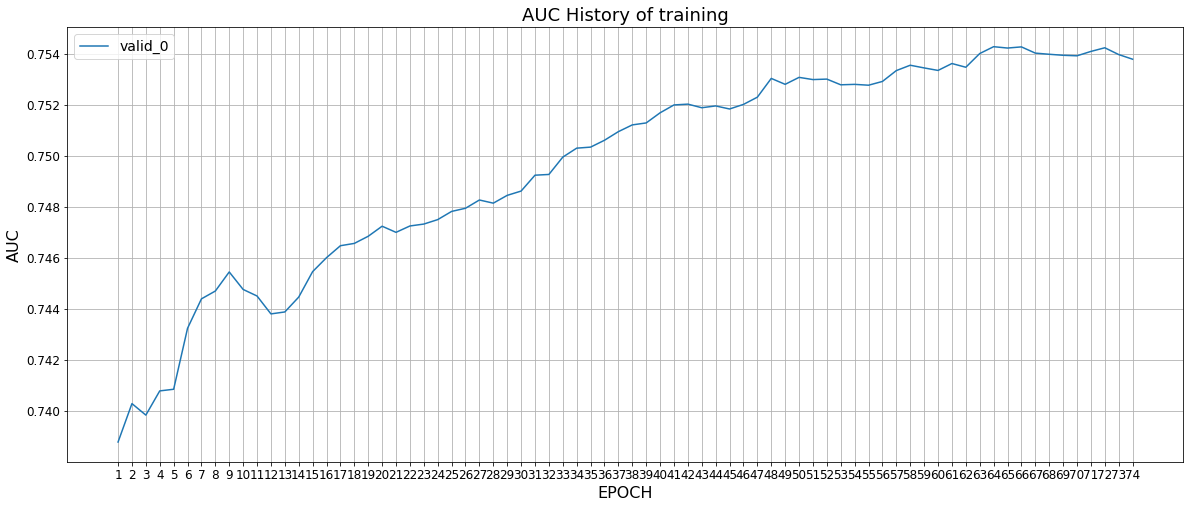

In [48]:
def plot_history(evals_result):
    for metric in ['auc']:
        plt.figure(figsize=(20,8))
        
        for key in evals_result.keys():
            history_len = len(evals_result.get(key)[metric])
            history = evals_result.get(key)[metric]
            x_axis = np.arange(1, history_len + 1)
            plt.plot(x_axis, history, label=key)
        
        x_ticks = list(filter(lambda e: (e % (history_len // 100 * 10) == 0) or e == 1, x_axis))
        plt.xticks(x_ticks, fontsize=12)
        plt.yticks(fontsize=12)

        plt.title(f'{metric.upper()} History of training', fontsize=18);
        plt.xlabel('EPOCH', fontsize=16)
        plt.ylabel(metric.upper(), fontsize=16)
        
        if metric in ['auc']:
            plt.legend(loc='upper left', fontsize=14)
        else:
            plt.legend(loc='upper right', fontsize=14)
        plt.grid()
        plt.show()

plot_history(evals_result)

In [49]:
# plot the feature importance in terms of gain and split
def show_feature_importances(model, importance_type, max_num_features=10**10):
    feature_importances = pd.DataFrame()
    feature_importances['feature'] = features
    feature_importances['value'] = pd.DataFrame(model.feature_importance(importance_type))
    feature_importances = feature_importances.sort_values(by='value', ascending=False) # sort feature importance
    feature_importances.to_csv(f'feature_importances_{importance_type}.csv') # write feature importance to csv
    feature_importances = feature_importances[:max_num_features] # only show max_num_features
    
    plt.figure(figsize=(20, 8))
    plt.xlim([0, feature_importances.value.max()*1.1])
    plt.title(f'Feature {importance_type}', fontsize=18);
    sns.barplot(data=feature_importances, x='value', y='feature', palette='rocket');
    for idx, v in enumerate(feature_importances.value):
        plt.text(v, idx, "  {:.2e}".format(v))

show_feature_importances(model, 'gain')
show_feature_importances(model, 'split')

NameError: name 'sns' is not defined

In [ ]:
# remove train and validation data to free memory before prediction phase
del train_data
gc.collect()

In [ ]:
# updates the user data
def update_user_data(state, features_questions_df, prev_test_df):
    for user_id, content_id, answered_correctly in prev_test_df[['user_id', 'content_id', 'answered_correctly']].values:
        # update user features
        state[user_id]['answered_correctly_user'] += answered_correctly
        state[user_id]['answered_user'] += 1
        state[user_id]['mean_user_accuracy'] = state[user_id]['answered_correctly_user'] / state[user_id]['answered_user']

In [ ]:
def get_user_data(state, test_df):
    # updated data
    attempt, mean_user_accuracy, answered_correctly_user, answered_user = [], [], [], []
    
    for idx, (user_id, content_id) in test_df[['user_id', 'content_id']].iterrows():
        # check if user exists
        if user_id in state:
            # check if user already answered the question, if so update it to a maximum of 4
            if content_id in state[user_id]['user_content_attempts']:
                state[user_id]['user_content_attempts'][content_id] = min(4, state[user_id]['user_content_attempts'][content_id] + 1)
            # if user did not answered the question already, set the number of attempts to 0
            else:
                state[user_id]['user_content_attempts'][content_id] = 0
        
        # else create user with default values
        else:
            dict_keys = ['mean_user_accuracy', 'answered_correctly_user', 'answered_user', 'user_content_attempts']
            dict_default_vals = [0.680, 0, 0, dict(zip([content_id],[0]))]
            state[user_id] = dict(zip(dict_keys, dict_default_vals))
            
        # add user data to lists
        attempt.append(state[user_id]['user_content_attempts'][content_id])
        mean_user_accuracy.append(state[user_id]['mean_user_accuracy'])
        answered_correctly_user.append(state[user_id]['answered_correctly_user'])
        answered_user.append(state[user_id]['answered_user'])
    
    return attempt, mean_user_accuracy, answered_correctly_user, answered_user

In [ ]:
import riiideducation

env = riiideducation.make_env()
iter_test = env.iter_test()

In [ ]:
prev_test_df = None
mean_attempt_acc_factor = FEATURES['mean_attempt_acc_factor']

for idx, (test_df, _) in tqdm(enumerate(iter_test)):
    # from 2nd iteration, update user data
    if prev_test_df is not None:
        prev_test_df['answered_correctly'] = eval(test_df['prior_group_answers_correct'].iloc[0])
        update_user_data(state, features_questions_df, prev_test_df.loc[prev_test_df['content_type_id'] == 0])
    
    # get user data from state and update attempt
    attempt, mean_user_accuracy, answered_correctly_user, answered_user = get_user_data(state, test_df)

    # set updated user data
    test_df['attempt'] = attempt
    test_df['mean_user_accuracy'] = mean_user_accuracy
    test_df['answered_correctly_user'] = answered_correctly_user
    test_df['answered_user'] = answered_user

    # merge with all features
    test_df = features_questions_df.merge(test_df, how='right', on='content_id')

    # fill prior question had explenation
    test_df['prior_question_elapsed_time'].fillna(23916, inplace=True)

    # add harmonic mean
    test_df['hmean_user_content_accuracy'] = 2 * (
        (test_df['mean_user_accuracy'] * test_df['mean_content_accuracy']) /
        (test_df['mean_user_accuracy'] + test_df['mean_content_accuracy'])
    )

    test_df['answered_correctly'] = model.predict(test_df[features])

    env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])

    # set previour test_df
    prev_test_df = test_df.copy()